<a href="https://colab.research.google.com/github/joesamrodrigues/odw-2020/blob/master/Rodrigues_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Analysis of GW190521

For this assignment, you will have to conduct an analysis of the gravitational-wave signal GW190521. This analysis should be done within a Jupyter notebook, with many comments in [Markdown](https://colab.research.google.com/notebooks/markdown_guide.ipynb) desribing and **justifying** the steps taken.

- The writing should be at the level of a fellow student of the class
- Submit **both** the .ipybn file and the converted .pdf file:
  - submit the .pdf file to TurnitIn (make sure all the cells have been run).
  - and the .ipynb file by e-mail with the subject "PXT903/PX4236 Final Project"
- Describe **in details** every step of your analysis throughout the notebook.
- Any setting choice (sampling rate, window parameter, FFT length, etc...) needs to be justified, either by its own investigation or relevant citations from the literature.
- Code alone, without a detailed descriptions of what is done and why, is worth half marks at the most.

NOTE: you can use any of the notebooks covered in the class, or code available online, _provided that you justify the settings and methods used_.

## Introduction (15 points)
Minimum 300 words.
- Write an introduction to this analysis, citing the relevant context and literature.
- Write a short summary of what is done in the notebook.

GW190521 is a short duration (0.1 s) gravitational wave signal with SNR of 14.7 and FAR (False Alarm Rate) of 1 in 4900 years. The day this event was detected there was a detection of another signal on the same day which raised eyebrows. Although, with bit of scepticism because of the short duration of the wave later it was estimated that it is coalescence between two black holes, one with 85 solar masses and the other with 66 solar masses at 5.3 Gpc. The remnant black hole was a IMBH with mass 142 solar masses. The analysis suggests the gravitational wave being in 30Hz to 80Hz. Different approximants produce different values for the SNR and FAR.
Citation-(https://doi.org/10.1103/PhysRevLett.125.101102)
I am creating a noise model of the data by looking at the Q-transform of the data to by-eye estimate where the gravitational signal is.
Cleaning up the data: I resampled, whitened, band passed and windowed the data to weed out the unnecessary frequency that is known to be not contain any required data and to normalise the frequency across the length of the signal. I am cropping the data wherever necessary tin the process.
Noise model: Calculating the power spectral density of the data gives the noise model.
Signal model: Using Pycbc approximants like "SEOBNRv4_opt” and “gausspulse” that generate waveforms I have tried to by-eye match the template to the observed data. This allowed me to guess initial values that can use for parameters.
Detection: To actual know whether a gravitational wave has been detected, there are multiple parameters that are considered. Here I have calculated the SNR , a ratio that tells whether an observed signal in a detector is significant or it is just noise.
Parameter estimation: In this part I have used previously mentioned approximants and the best parameter values guessed to produce waveforms and then use minimize() function to fit the waveform to the data. Loglikelihood, prior and posterior are estimated  which will give significance of the data observed and the estimated parameters.


## The data and noise model (10 points)

- Download and plot the relevant gravitational-wave data for GW190521.
- Compute and plot the Power Spectrum Density.
- Compute and plot the whitened data. Use filters if necessary to best highlight where the signal is (or might be).

Importing the relevant packages needed

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
! pip install -q gwpy
! pip install -q lalsuite pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━

In [3]:
from gwosc.datasets import event_gps
from gwpy.time import to_gps
from gwpy.time import from_gps
from pycbc.waveform import get_td_waveform
from gwpy.timeseries import TimeSeries
from pycbc.types import timeseries
from pycbc.detector import Detector

/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [4]:
gps = event_gps('GW190521')
print('Time of the event',gps)

Time of the event 1242442967.4


In [5]:
print(from_gps(gps))

2019-05-21 03:02:29.400000


In [6]:
segment = (int(gps)-16, int(gps)+16)
print(segment)

(1242442951, 1242442983)


In [7]:
duration_of_data=segment[1]-segment[0]
print(duration_of_data)

32


In [8]:
time_center=gps

Downloading the data of the event from each detector. I have resampled the data to 2048Hz (Nyquist frequency) because the analysis of the event published in this paper (https://doi.org/10.1103/PhysRevLett.125.101102) suggests that the GW is detected around 30 to 80 Hz, there are no frequencies above 1024 Hz that I should be worried about. Resampling is not the same as bandpassing, more of like disregarding certain data points where high frequency noise appears.

In [9]:
data={} # an empty dictionary
ifos=['L1','H1','V1'] # a list which we use as the dictionary keys
for ifo in ifos:
    data[ifo] = TimeSeries.fetch_open_data(ifo, time_center - 512, time_center + 512)
    data[ifo]=data[ifo].resample(2048)

/usr/local/lib/python3.10/dist-packages/gwpy/plot/axes.py:190: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


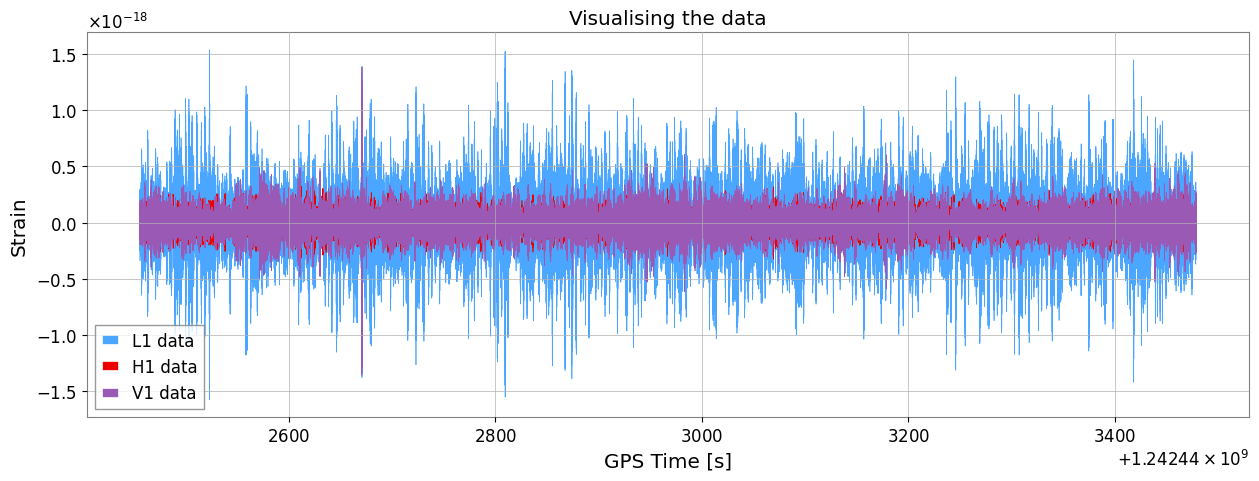

In [10]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:ligo-hanford','gwpy:virgo']


for ifo,colour in zip(ifos,colours):
    plt.plot(data[ifo],label='{} data'.format(ifo),color=colour, linewidth=0.5)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('Visualising the data')
plt.legend();

Above, I have downloaded event data that is 1024 seconds long. This gives me a chance to normalise over all the noise including transient noise if any when whitening the data.

Below, I have plotted a Qtransform of the data to visualise where the signal is evident. As we can see it is visible between the range of 30 Hz to 100 Hz. Also, the same signal is evident in all of the other detectors as well, except the Virgo detector which has a lower sensitivity.

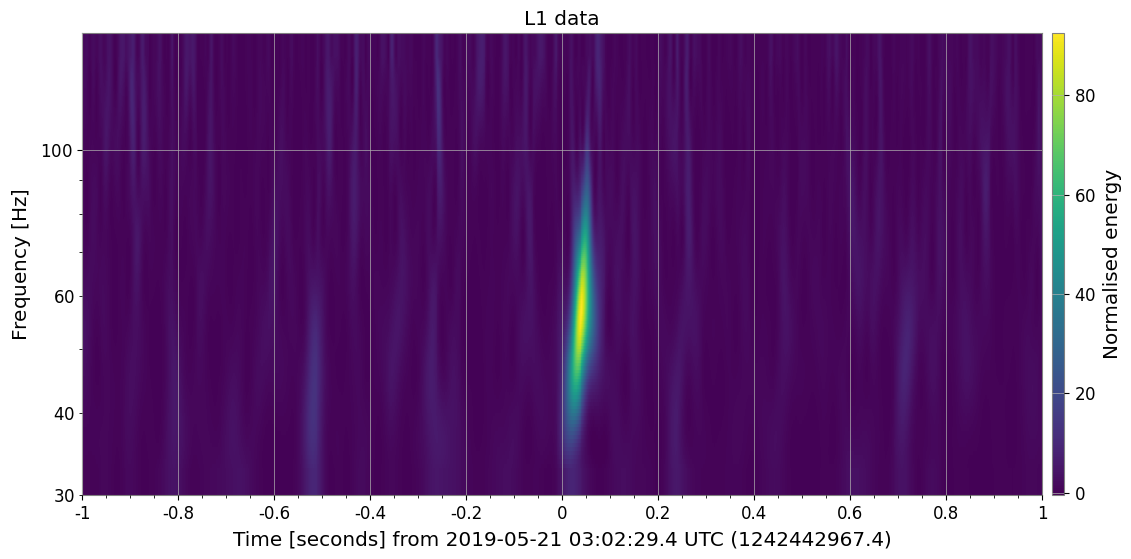

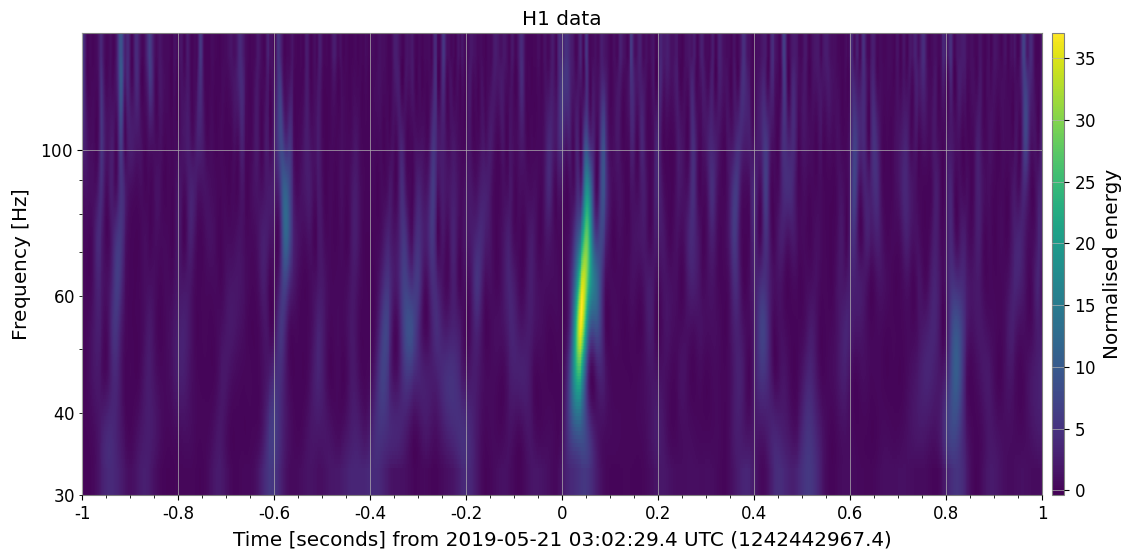

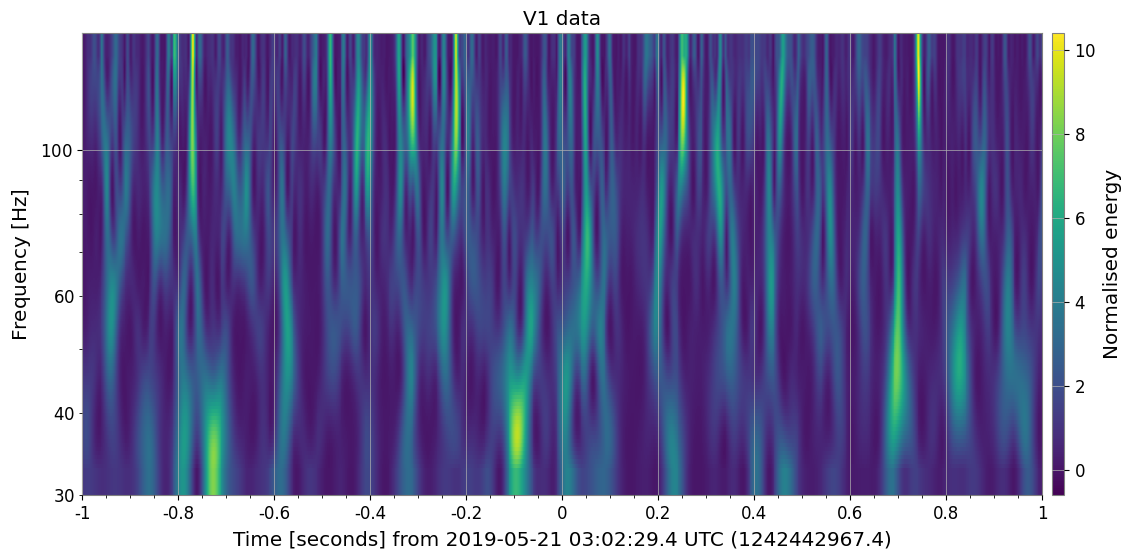

In [11]:
hq={}
for ifo,colour in zip(ifos,colours):
  hq[ifo] = data[ifo].q_transform(frange=(30, 150),outseg=(time_center - 1, time_center + 1))
  plot=hq[ifo].plot()
  ax = plot.gca()
  ax.set_epoch(gps)
  ax.set_yscale('log')
  ax.colorbar(label="Normalised energy")
  ax.set_title('{} data'.format(ifo))

Calculating the Power Spectral Density (PSD) of the data to chack all the frequency range and what frequencies are strong.

In [12]:
psd_full={}
for ifo in ifos:
    psd_full[ifo] = data[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)


I have cropped and editted data throught this notebook to fit my convenience. Below, I have cropped the original data to 32 seconds, resampled it and taken a PSD of it.

The fft length is 4 with an overlap of 2 which ensures that each part of the data is coverd when fft is calculated over length of 4. Windowing function smooths down the edges, just to makes sure there are no artefacts generated during the calculation of fft in chunks. 1/4 is the length of the edge that is being windowed.

In [13]:
data_32={}
psd_32={}
for ifo in ifos:
  data_32[ifo]=data[ifo].resample(2048).crop(gps-16, gps+16)
  psd_32[ifo]=data_32[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

/usr/local/lib/python3.10/dist-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (2048.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


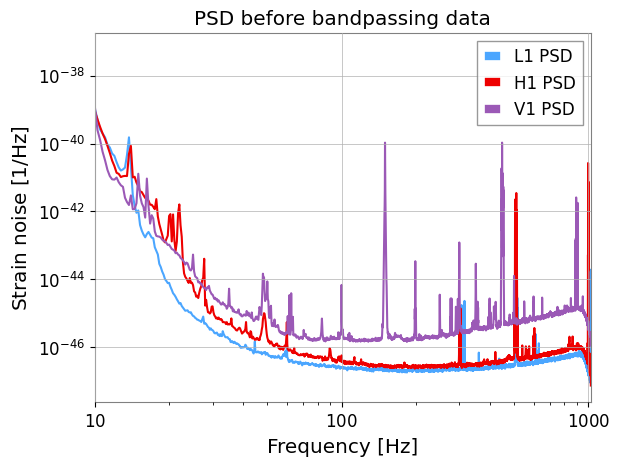

In [14]:
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd_full[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.title('PSD before bandpassing data')
plt.xlim(10,1024)
plt.legend();

Clearly there are lot of noise in the signal. More easier way to look at the data will be to whiten it and bandpass it which I do in the next section.

###Whitenening the data

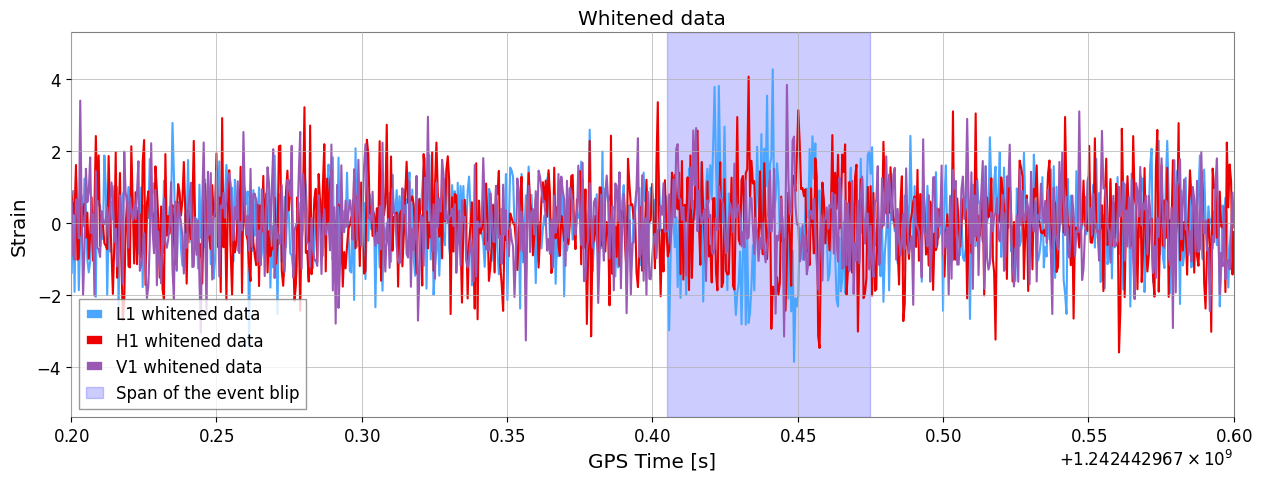

In [15]:
plt.figure(figsize=(15,5))

white_data={}
whitened_data={}
for ifo,colour in zip(ifos,colours):
    whitened_data[ifo]=data[ifo].whiten(fftlength=4)
    white_data[ifo]=whitened_data[ifo].crop(gps - 16,gps + 16)
    plt.plot(white_data[ifo],label='{} whitened data'.format(ifo),color=colour)
plt.xlim(time_center-.2, time_center+.2)
#plt.ylim(-2,2)
plt.axvspan(gps+0.005, gps+.075,alpha=0.2, color='b',label='Span of the event blip')
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('Whitened data')
plt.legend();

In [16]:
print(white_data['H1'].duration)

32.0 s


Whitened data is normalised acroos the noise which gives a flat PSD like seen below.

In [17]:
psd1={}
for ifo in ifos:
    psd1[ifo] = white_data[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

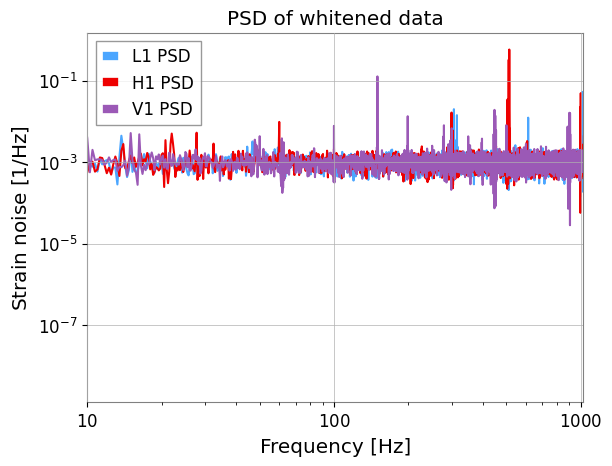

In [18]:
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd1[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.title('PSD of whitened data')
plt.xlim(10,1024)
plt.legend();

###Bandpassing and resampling the whitened data

In [19]:
data_filt={}
# Remove the low and high frequency content
for ifo in ifos:
    data_filt[ifo] = white_data[ifo].bandpass(30,120)

Bandpassing the data removes all the frequencies above and belowe the specified frequency range which take sout all the uneccessary processing and frequencies that does not hold any data.

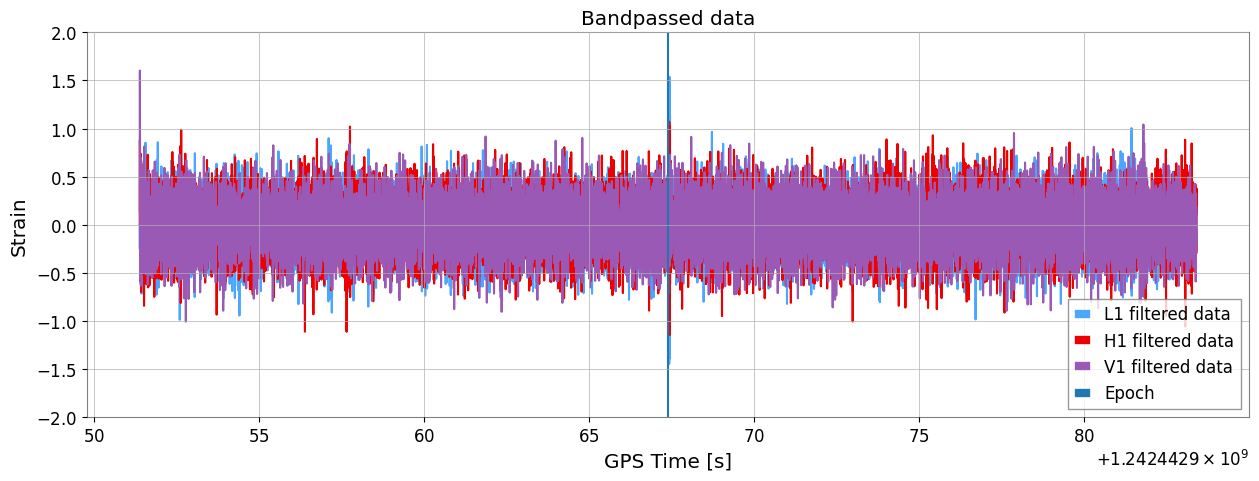

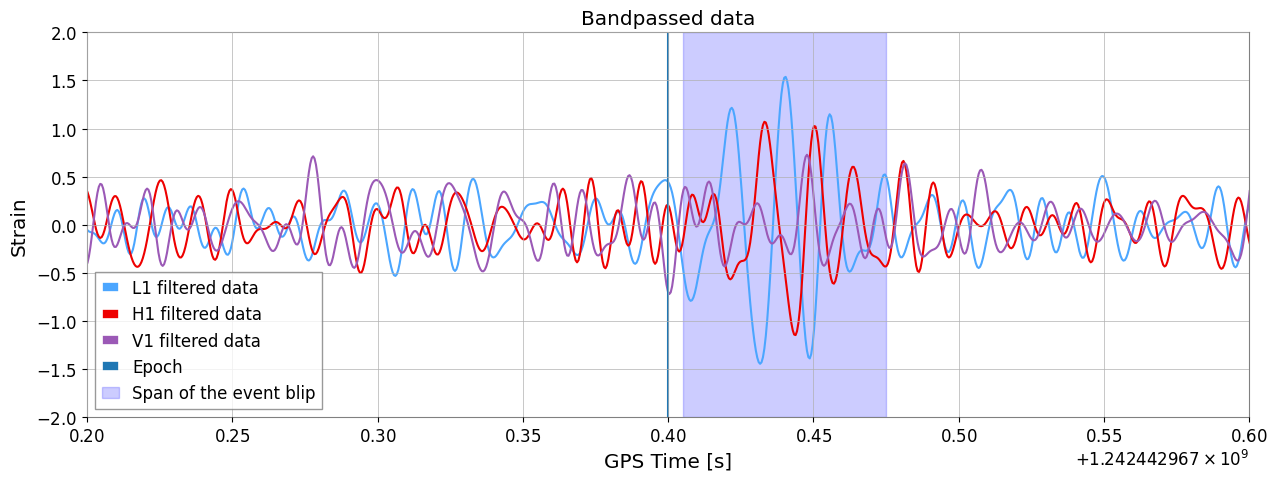

In [20]:
plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
  plt.plot(data_filt[ifo],label='{} filtered data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.axvline(gps, label='Epoch')
#plt.xlim(time_center-.2, time_center+.2)
plt.ylim(-2,2)
plt.title('Bandpassed data')
plt.legend();

plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
  plt.plot(data_filt[ifo],label='{} filtered data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.axvline(gps, label='Epoch')
plt.axvspan(gps+0.005, gps+.075,alpha=0.2, color='b',label='Span of the event blip')
plt.xlim(time_center-.2, time_center+.2)
plt.ylim(-2,2)
plt.title('Bandpassed data')
plt.legend();

You can see the data is much more clear and has most of the noise taken out.

In [21]:
psd2={}
for ifo in ifos:
    psd2[ifo] = data_filt[ifo].psd(fftlength=4.,window=('tukey',1./4.),method='welch',overlap=2.)

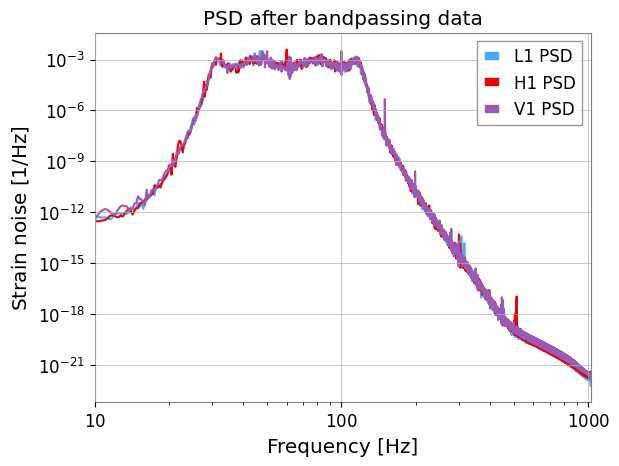

In [22]:
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd2[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.title('PSD after bandpassing data')
plt.xlim(10,1024)
plt.legend();

####Cropped data to 4 sec

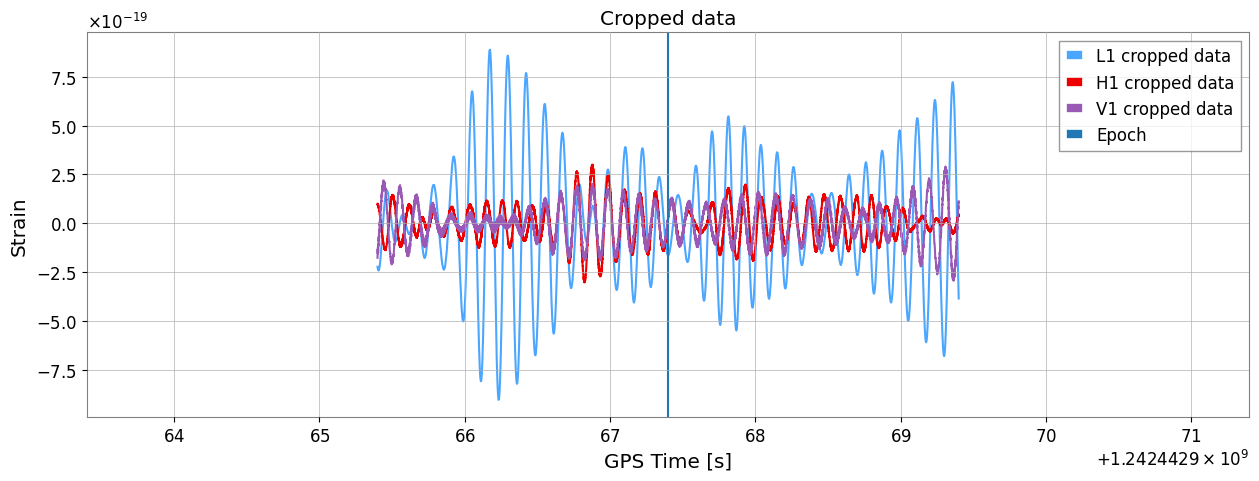

In [23]:
plt.figure(figsize=(15,5))
cropped_data={}

for ifo,colour in zip(ifos,colours):
  #Retain only 4 seconds on either side of the gps time
  cropped_data[ifo] = data[ifo].crop(gps-2, gps+2)
  plt.plot(cropped_data[ifo],label='{} cropped data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('Cropped data')
plt.xlim(time_center-4, time_center+4)
plt.axvline(gps, label='Epoch')
plt.legend();

I have cropped the data to 4 seconds length to use it in parameter estimation later in the notebook.

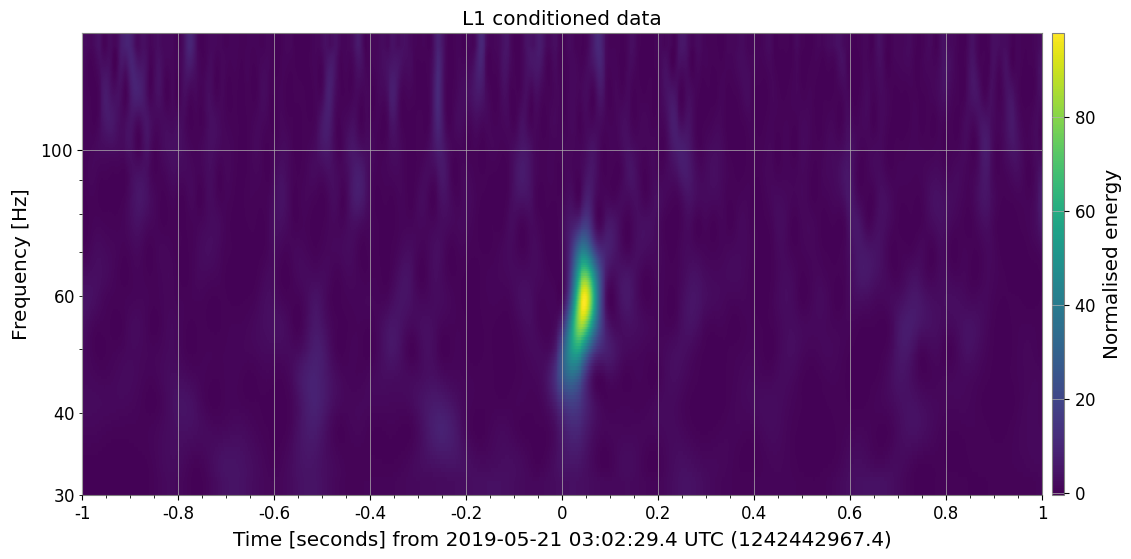

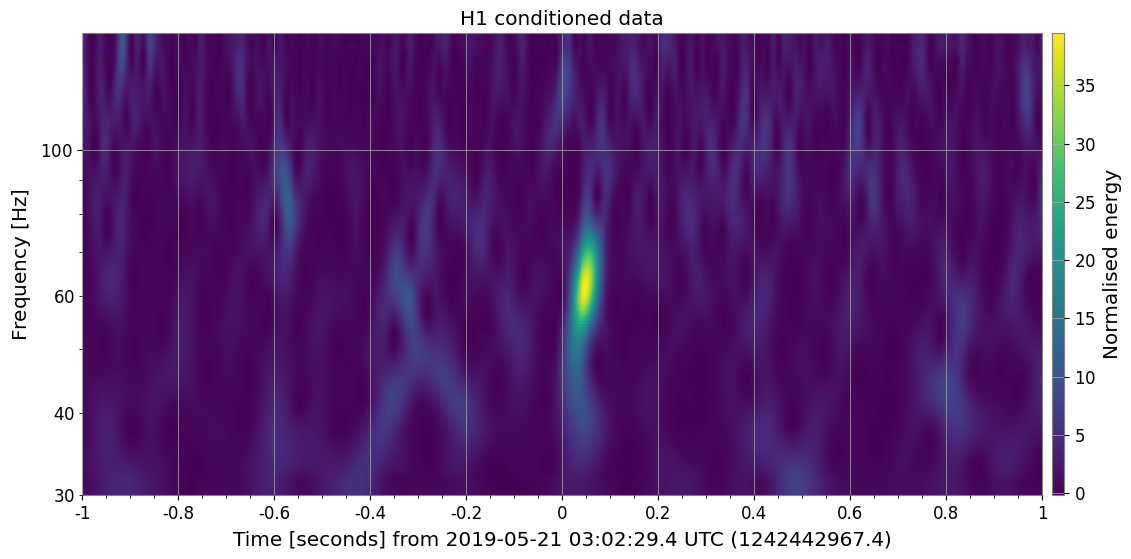

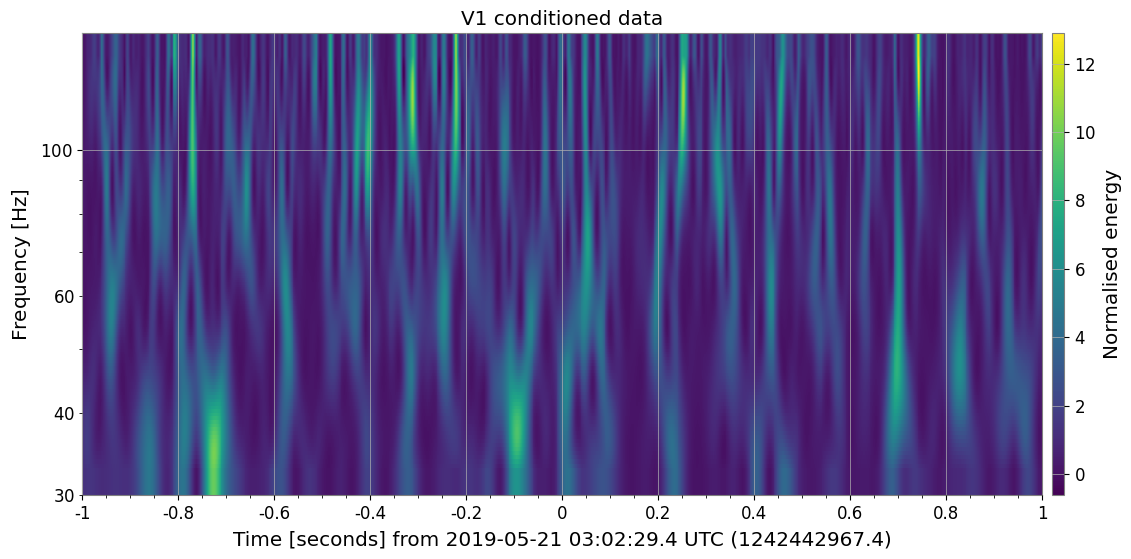

In [24]:
hq1={}
for ifo,colour in zip(ifos,colours):
  hq1[ifo] = data_filt[ifo].q_transform(frange=(30, 150),outseg=(time_center - 1, time_center + 1))
  plot1=hq1[ifo].plot()
  ax = plot1.gca()
  ax.set_epoch(gps)
  ax.set_yscale('log')
  ax.colorbar(label="Normalised energy")
  ax.set_title('{} conditioned data'.format(ifo))

32 Seconds long bandpassed data

In [25]:
data_bandpassed={}
# Remove the low and high frequency content
for ifo in ifos:
    data_bandpassed[ifo] = data[ifo].bandpass(30,120).resample(2048).crop(gps-16, gps+16)

## The signal model (10 points)

- Generate and plot a CBC signal which you expect to be a good match for the signal. Use the literature, and cite your sources
- Generate and plot a phenomenological model (sometimes refer to as a "Burst" model). A model whose parameters describe the shape of the waveform itself, not the source.
- Compute the overlap between those those two signals, and try to find parameters that maximises that overlap.

NOTE: remember that gravitational-wave are redshifted.

In [26]:
from scipy.signal import get_window

In [27]:
print(data_bandpassed['H1'].sample_rate.to_value())

2048.0


###CBC Model

I am generating a CBC(Compact binary coalescence) mosdel using a pycbc waveform approximant called "SEOBNRv4_opt" which generates inspiral , merger, and ringdown part of gravitational wave. This is a time domain model which generated gravitational waveforms based on the parameter the user inputs.(https://zenodo.org/badge/latestdoi/31596861) (https://pycbc.org/pycbc/latest/html/waveform.html)

I have taken all the parameters to generate the waveform from the paper (https://doi.org/10.1103/PhysRevLett.125.101102). I need to give approximately close enough value of the parameters for the generated waveform to be matching or atleast comparable with the data in the signal.

Primary mass = 85 solar masses , with redshifted mass of 154 solar masses
Secondary mass = 66 solar mass, with redshifted mass of 120 solar mass

Distance = 5300 MPc
Inclination = 0.3 rad
Spin 1 and Spin 2 being 0.69 and 0.73 respectively.

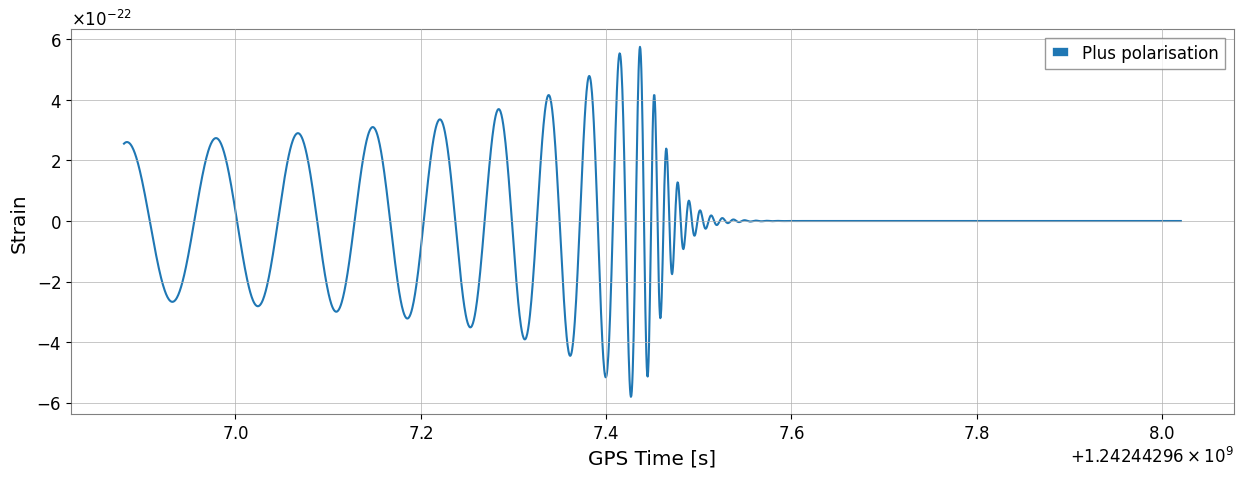

In [28]:
m1 = 85*1.82 # Solar masses
m2 = 66*1.82 # Solar masses

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1./data_bandpassed['H1'].sample_rate.to_value(),
                         distance=5300,
                         f_lower=10,
                         inclination=0.3,
                         spin1z=0.69,
                         spin2z=0.73)
hp.start_time=gps-0.52
plt.figure(figsize=(15,5))
plt.plot(hp.sample_times, hp, label='Plus polarisation')
#plt.plot(hp.sample_times, hp*get_window(('tukey',1/6),hp.shape[0]),label='After Taper')
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()

Comparing the waveformto the cleaned data and by-eye fitting it on the data by tweaking the start time of the model waveform.

Text(0.5, 1.0, 'CBC Model overlay')

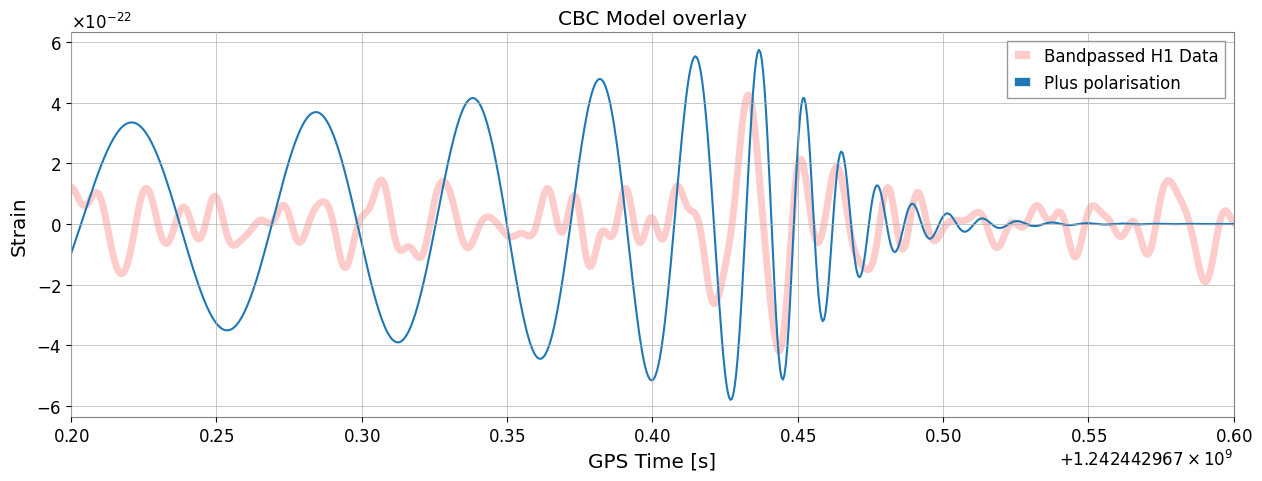

In [29]:
plt.figure(figsize=(15,5))

plt.plot(data_bandpassed['H1'].times, data_bandpassed['H1'], 'red', label='Bandpassed H1 Data', linewidth=5, alpha=0.2)
plt.plot(hp.sample_times, hp, label='Plus polarisation')
plt.legend()
plt.xlim(gps-.2,gps+.2)

plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('CBC Model overlay')

##Burst model

In [30]:
from scipy.signal import gausspulse

Here I am using the burst model i.e. Phenomenological model which only considers the parameters like frequency, bandwidth and amplitude of the waveform rather than the source.

fc is Central frequency, bw - bandwidth (range of frequencies in the gravitational wave) and 4e-22 indicated the amplitude of the waveform.

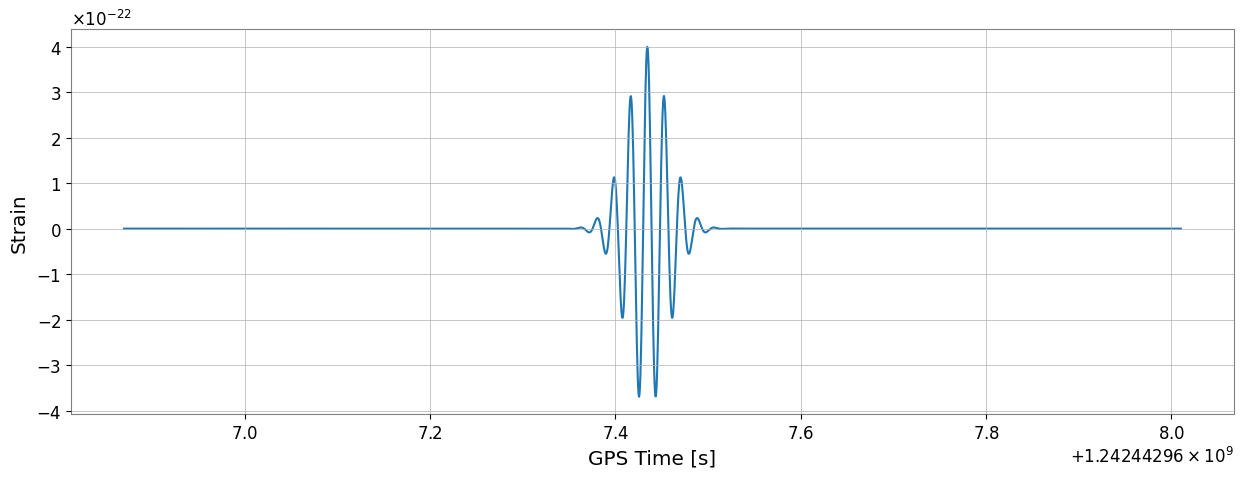

In [31]:
m1 = 85*1.82 # Solar masses
m2 = 66*1.82 # Solar masses

hp_1, hc_1 = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1./data_filt['H1'].sample_rate.to_value(),
                         distance=5300,
                         f_lower=10,
                         inclination=0.3,
                         spin1z=0.69,
                         spin2z=0.73)


burst=gausspulse(hp_1.sample_times, fc=55, bw=0.3)*4e-22*get_window(('tukey',1/4),hp_1.shape[0])
hp_burst= timeseries.TimeSeries(burst, delta_t=1./data_filt['H1'].sample_rate.to_value(), epoch=gps-0.53)


plt.figure(figsize=(15,5))
plt.plot(hp_burst.sample_times, hp_burst)
#plt.xlim(-0.1,0.1)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain');

Comparing it with the cleaned data to estimate the start time and approximately fit the waveform onto the data signal.

Text(0.5, 1.0, 'Burst Model overlay')

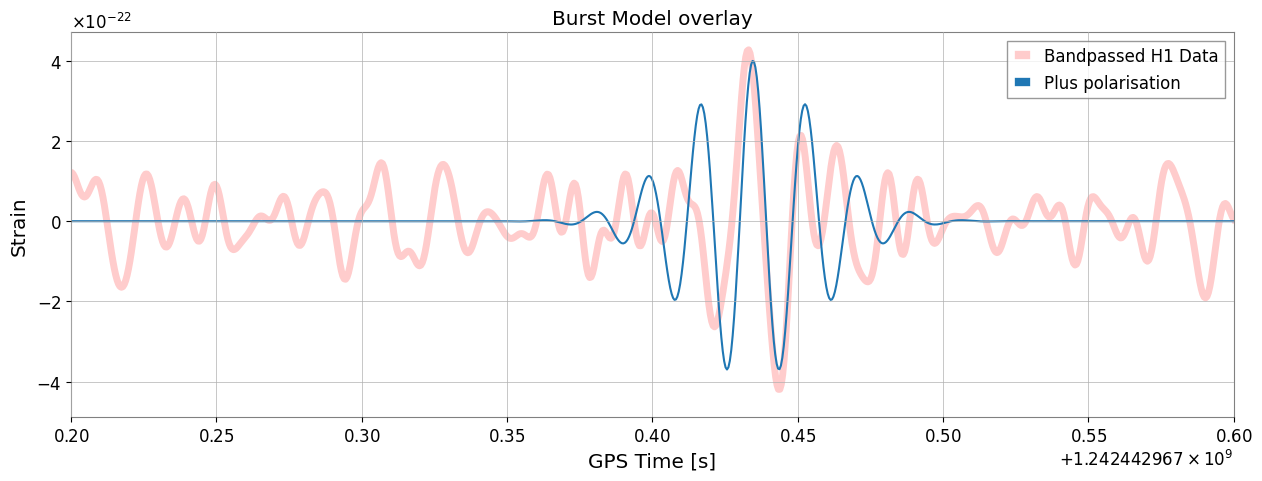

In [32]:
plt.figure(figsize=(15,5))

plt.plot(data_bandpassed['H1'].times, data_bandpassed['H1'], 'red', label='Bandpassed H1 Data', linewidth=5, alpha=0.2)
plt.plot(hp_burst.sample_times, hp_burst, label='Plus polarisation')
plt.legend()
plt.xlim(gps-.2,gps+.2)
#plt.ylim(-1,1)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('Burst Model overlay')

In [33]:
from scipy.signal import correlate

Here I am measuring the correlation between the data and each of the model. It is evident that both the model fit approximately with the data giving almost the same correlation pattern.

The CBC model waveform has more amplitude beacuse of the inspiral part of it. Burst model just defines, well "burst", a tiny section of the GW which does not really define the data observed. On the other hand CBC model tells us the part of the signal that we are not sensitive to.

<ipython-input-34-669172544ddb>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


Text(0.5, 1.0, 'Correlation of burst model with the data')

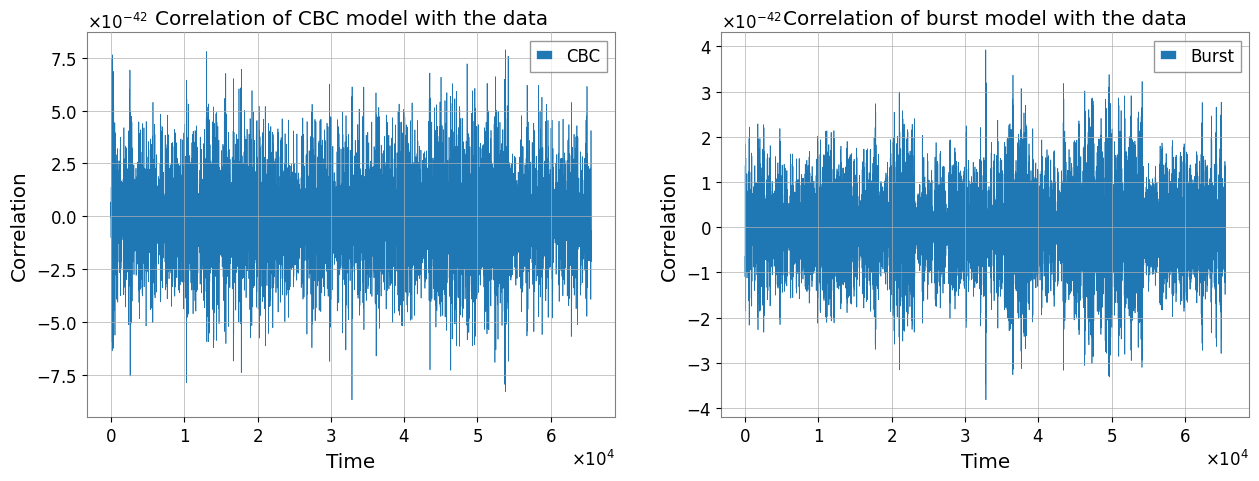

In [34]:
plt.figure(figsize=(15,5))
plt.title('Correlation of CBC and burst model with the data')
plt.subplot(121)
plt.plot(correlate(data_bandpassed['H1'],hp,mode='same'), label='CBC', linewidth=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Correlation of CBC model with the data')

plt.subplot(122)
plt.plot(correlate(data_bandpassed['H1'],hp_burst,mode='same'), label='Burst', linewidth=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.title('Correlation of burst model with the data')

## Detection (25 points)
Limiting yourself to a coincident (**not** coherent) analysis:
- Compute the SNR time series for the CBC signal model
- Compute the SNR time series for the Burst signal model
- Discuss the differences, if any.
- Estimate a bound on the False Alarm Rate of the detection.

###SNR using CBC model

SNR( Signal to Noise Ratio) tells us how significant is an observed signal that we can consider as a gravitational wave. SNR dpends on the sensitivity of the signal. Here I use template as the signal and compare it to the noise model that
I created in the beginning of the notebook. The ratio of these gives the SNR

In [35]:
m1 = 85*1.82 # Solar masses
m2 = 66*1.82 # Solar masses

hp2, hc2 = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1./data_32['H1'].sample_rate.to_value(),
                         distance=5300,
                         f_lower=10,
                         coa_phase=0,
                         spin1z=0.69,
                         spin2z=0.73,
                         inclination=0.3)


hp2=hp2*get_window(('tukey',1/4),hp2.shape[0])
hc2=hc2*get_window(('tukey',1/4),hc2.shape[0])
#plt.plot(hp.sample_times, hp*get_window(('tukey',1/6),hp.shape[0]),label='After Taper')

# Making it 32 seconds:
hp2.prepend_zeros(np.ceil((16+hp2.start_time)/hp2.delta_t))
hp2.append_zeros(np.floor((16-hp2.end_time)/hp2.delta_t))
hp2.start_time=gps-15.95
template=TimeSeries.from_pycbc(hp2)
template.duration

<Quantity 32. s>

Template is of 32 seconds

Text(0.5, 1.0, 'CBC Model overlay')

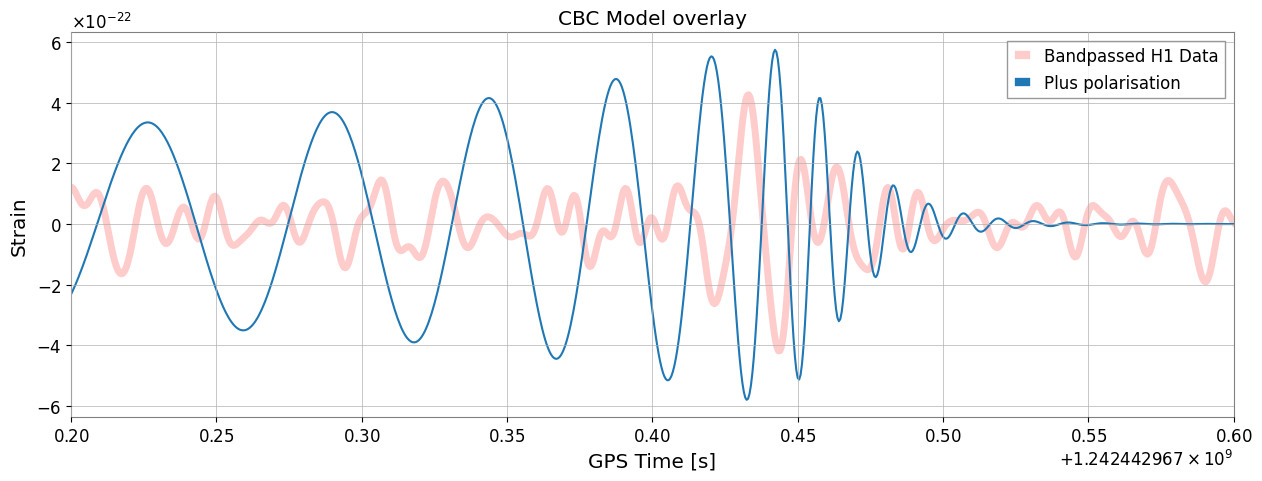

In [36]:
plt.figure(figsize=(15,5))

plt.plot(data_bandpassed['H1'].times, data_bandpassed['H1'], 'red', label='Bandpassed H1 Data', linewidth=5, alpha=0.2)
plt.plot(hp2.sample_times, hp2, label='Plus polarisation')
plt.legend()
plt.xlim(gps-.2,gps+.2)

plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.title('CBC Model overlay')

I am taking data of 32 seconds of data, take fft of it and normalising it with the length of the data.


This process is much simpler to do in the frequency domain than in the time domain. Template(modelled waveform) is being converted into frequency domain as well.

In [37]:
# FFT of the data, with the appropriate normalisation
data_f={}
for ifo in ifos:
  data_f[ifo]=data_32[ifo].average_fft(window=('tukey',1./4.))*(data_32[ifo].duration/2)
# data_f=data['H1'].average_fft(window=('tukey',1./4.))*(data['H1'].duration/2)

In [38]:
# FFT of the template, with the appropriate normalisation
template_f=template.average_fft(window=('tukey',1./4.))*(template.duration/2)

In [39]:
# We will need the PSD with the same frequency spacing as the data and template,
# so we interpolate it to match:
PSD_interp={}
for ifo in ifos:
  PSD_interp[ifo]=psd_32[ifo].interpolate(data_f[ifo].df.value)

In [40]:
# With the right normalisation, this is equation 7.58 of the textbook:
optimal={}
opt_time={}
for ifo in ifos:
  optimal[ifo]=data_f[ifo]*template_f.conjugate()/PSD_interp[ifo]
  opt_time[ifo]=2*optimal[ifo].ifft()*(optimal[ifo].df*2)

The above piece of code is defined by the mathematical equation:

$x(t):=2 ∫\dfrac{s(f)g(f)}{S_n(F)}e^{2\pi i f t}df$  from "Gravitational-Wave Physics and Astronomy - Jolien D.E. Creighton"



Match filter the data, scan through the data section by section to compute the loudness of the signal at each section.

In [41]:
# This is equation 7.49 of the textbook: the overlap of the template with itself
sigmasq = 4 * np.real((template_f * template_f.conjugate() / PSD_interp[ifo]).sum() * template_f.df)
sigma = np.sqrt(np.abs(sigmasq))

SNR_complex={}
# And now we have the SNR time series:
for ifo in ifos:
  SNR_complex[ifo] = opt_time[ifo]/sigma

In [42]:
# We can recenter thing with the location of peak in the template:
peaksample = template.argmax()

SNR1={}
for ifo in ifos:
  SNR_complex[ifo] = np.roll(SNR_complex[ifo],peaksample)
  SNR1[ifo] = abs(SNR_complex[ifo])

In [43]:
SNRmax={}
time_max={}

for ifo in ifos:
  SNRmax[ifo]=SNR1[ifo].max().value
  time_max[ifo]=SNR1[ifo].times[SNR1[ifo].argmax()]
  print('Maximum SNR[{}] of {} at {}.'.format(ifo,SNRmax[ifo],time_max[ifo]))

Maximum SNR[L1] of 26.87335036088145 at 1242442967.432617 s.
Maximum SNR[H1] of 14.925174359457053 at 1242442967.4428709 s.
Maximum SNR[V1] of 4.2990706040049655 at 1242442955.6518552 s.


SNR of Livingston being the prominent among the detectors, this is what my calculations show.

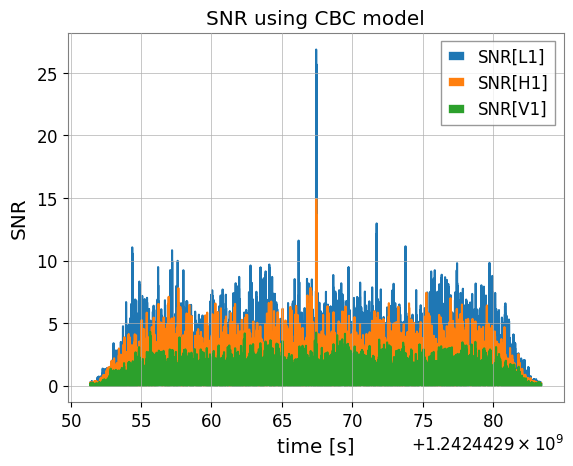

In [44]:
for ifo in ifos:
  plt.subplot()
  plt.plot(SNR1[ifo].times,SNR1[ifo],label=('SNR[{}]'.format(ifo)))
  plt.xlabel('time [s]')
  plt.ylabel('SNR')
  plt.title('SNR using CBC model')
  plt.legend();

####SNR using burst model

In [45]:
m1 = 85*1.82 # Solar masses
m2 = 66*1.82 # Solar masses

hp3, hc3 = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m1,
                         mass2=m2,
                         delta_t=1./data_filt['H1'].sample_rate.to_value(),
                         distance=5300,
                         f_lower=10,
                         coa_phase=0,
                         spin1z=0.69,
                         spin2z=0.73,
                         inclination=0.3)

hp3=hp3*get_window(('tukey',1/4),hp3.shape[0])
hc3=hc3*get_window(('tukey',1/4),hc3.shape[0])

hp3.prepend_zeros(np.ceil((16+hp3.start_time)/hp3.delta_t))
hp3.append_zeros(np.floor((16-hp3.end_time)/hp3.delta_t))

burst1=gausspulse(hp3.sample_times, fc=55, bw=0.3)*3.5e-22*get_window(('tukey',1/4),hp3.shape[0])
hp_burst_timeseries= timeseries.TimeSeries(burst1, delta_t=1./data_32['H1'].sample_rate.to_value(), epoch=gps-0.08)


#hp1_burst.start_time=gps-15.95
template_burst=TimeSeries.from_pycbc(hp_burst_timeseries)
template_burst.duration

<Quantity 32. s>

In [46]:
# FFT of the template, with the appropriate normalisation
template_f_burst=template_burst.average_fft(window=('tukey',1./4.))*(template_burst.duration/2)

In [47]:
# We will need the PSD with the same frequency spacing as the data and template,
# so we interpolate it to match:
PSD_interp={}
for ifo in ifos:
  PSD_interp[ifo]=psd_32[ifo].interpolate(data_f[ifo].df.value)

In [48]:
# With the right normalisation, this is equation 7.58 of the textbook:
optimal={}
opt_time={}
for ifo in ifos:
  optimal[ifo]=data_f[ifo]*template_f_burst.conjugate()/PSD_interp[ifo]
  opt_time[ifo]=2*optimal[ifo].ifft()*(optimal[ifo].df*2)

In [49]:
# This is equation 7.49 of the textbook: the overlap of the template with itself
sigmasq = 4 * np.real((template_f_burst * template_f_burst.conjugate() / PSD_interp[ifo]).sum() * template_f_burst.df)
sigma = np.sqrt(np.abs(sigmasq))

SNR_complex={}
# And now we have the SNR time series:
for ifo in ifos:
  SNR_complex[ifo] = opt_time[ifo]/sigma

In [50]:
# We can recenter thing with the location of peak in the template:
peaksample = template.argmax()

SNR2={}
for ifo in ifos:
  SNR_complex[ifo] = np.roll(SNR_complex[ifo],peaksample)
  SNR2[ifo] = abs(SNR_complex[ifo])

In [51]:
SNRmax={}
time_max={}

for ifo in ifos:
  SNRmax[ifo]=SNR2[ifo].max().value
  time_max[ifo]=SNR2[ifo].times[SNR2[ifo].argmax()]
  print('Maximum SNR[{}] of {} at {}.'.format(ifo,SNRmax[ifo],time_max[ifo]))

Maximum SNR[L1] of 29.0474439601386 at 1242442967.4316404 s.
Maximum SNR[H1] of 13.170812836898591 at 1242442967.4335935 s.
Maximum SNR[V1] of 4.87405418783415 at 1242442969.2724607 s.


SNR values slightly vary with a different template used.

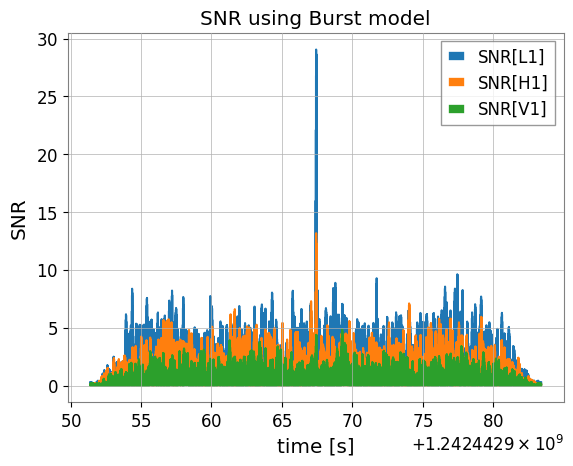

In [52]:
for ifo in ifos:
  plt.subplot()
  plt.plot(SNR2[ifo].times,SNR2[ifo],label=('SNR[{}]'.format(ifo)))
  plt.xlabel('time [s]')
  plt.ylabel('SNR')
  plt.title('SNR using Burst model')
  plt.legend();

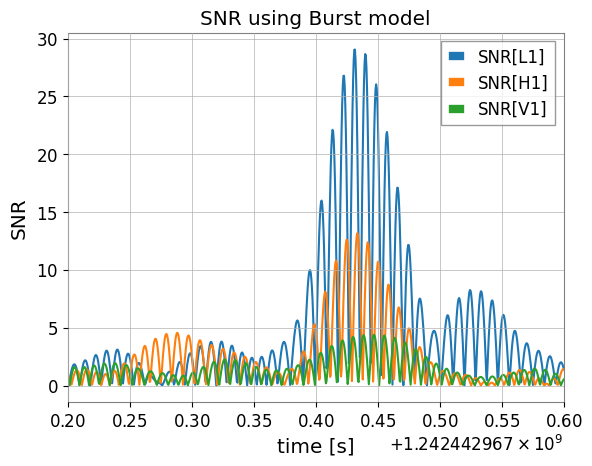

In [53]:
for ifo in ifos:
  plt.subplot()
  plt.plot(SNR2[ifo].times,SNR2[ifo],label=('SNR[{}]'.format(ifo)))
  plt.xlabel('time [s]')
  plt.ylabel('SNR')
  plt.xlim(plt.xlim(gps-.2,gps+.2))
  plt.title('SNR using Burst model')
  plt.legend();

In [54]:
window_size={}
sidx={}
eidx={}

# convert the times to indices along with how large the region is in number of samples:
for ifo in ifos:
  window_size[ifo] = int((1) / SNR1[ifo].dt.value)
  sidx[ifo] = int((float(-0.25+time_center-SNR1[ifo].x0.value)) / SNR1[ifo].dt.value)
  eidx[ifo] = sidx[ifo] + window_size[ifo]

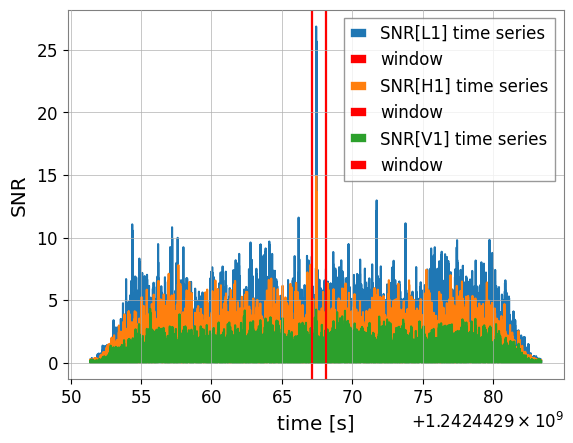

In [55]:
for ifo in ifos:
  plt.plot(SNR1[ifo],label=('SNR[{}] time series'.format(ifo)))
  plt.axvline(SNR1[ifo].times[sidx[ifo]].value,c='r',label='window')
  plt.axvline(SNR1[ifo].times[eidx[ifo]].value,c='r')
  plt.xlabel('time [s]')
  plt.ylabel('SNR')
  plt.legend();

#####Calculating the False alarm rate

In [56]:
# Calculate the "on-source" peak SNR statistic value.
onsource={}
for ifo in ifos:
  onsource[ifo] = SNR1[ifo][sidx[ifo]:eidx[ifo]].max()

In [57]:
# Now that we've calculated the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks = {}

p={}
for ifo in ifos:
  peaks[ifo]=[]
  i = 0
  while i + window_size[ifo] < len(SNR1[ifo]):
      p = SNR1[ifo][i:i+window_size[ifo]].max()
      peaks[ifo].append(p)
      i += window_size[ifo]

      # Skip past the onsource time
      if abs(i - sidx[ifo]) < window_size[ifo]:
          i += window_size[ifo] * 2

  peaks[ifo] = np.array([p.value for p in peaks[ifo]])

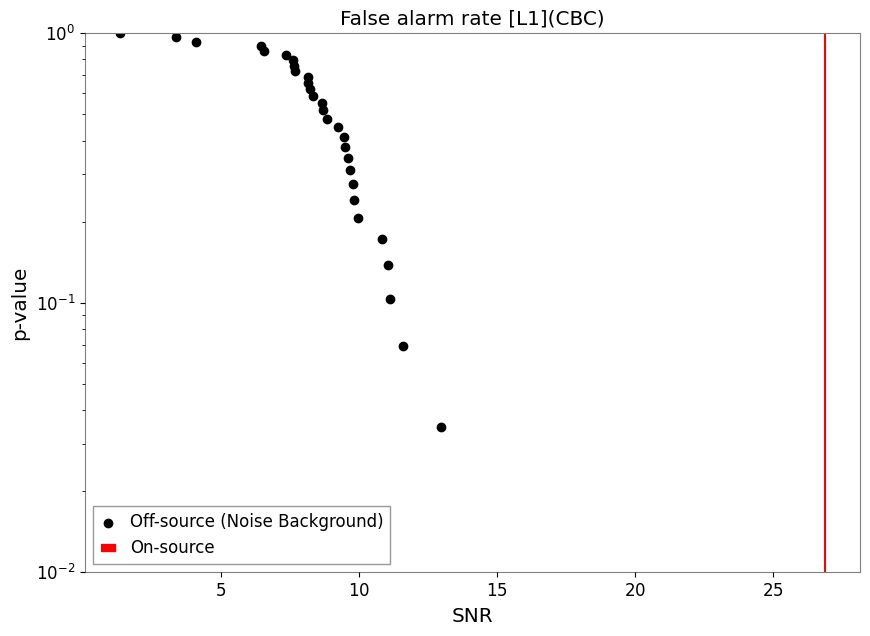

The p-value associated with the GW190521 peak is 0.0


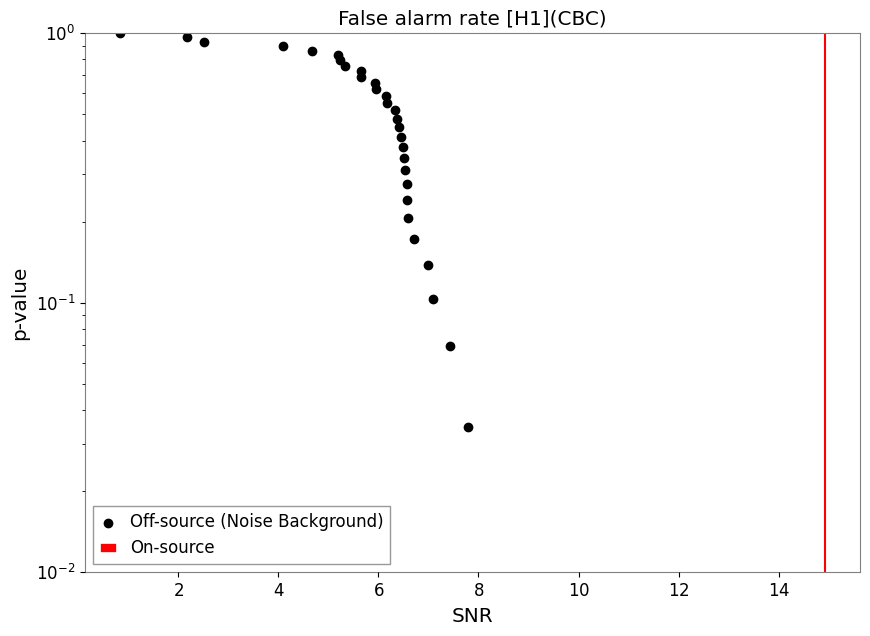

The p-value associated with the GW190521 peak is 0.0


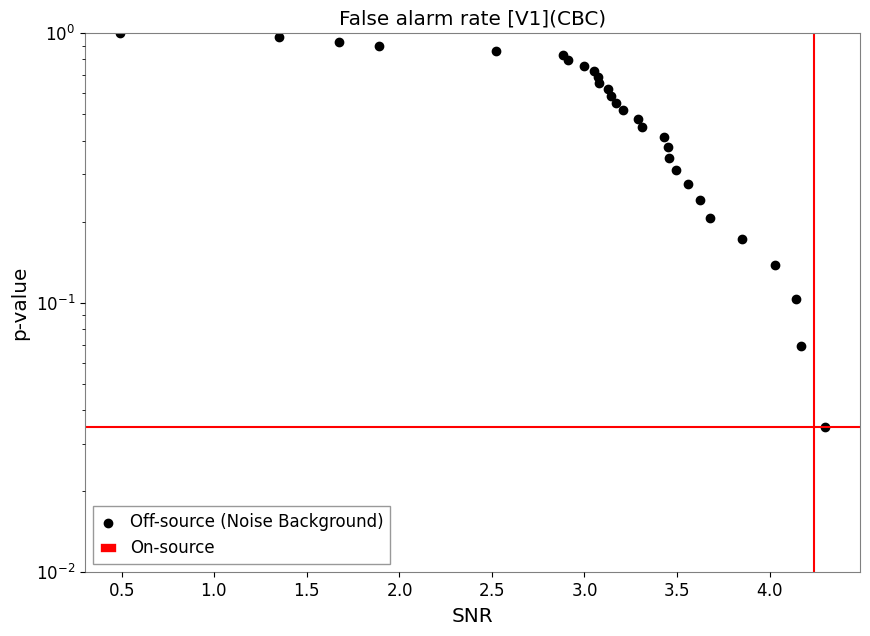

The p-value associated with the GW190521 peak is 0.034482758620689655


In [58]:
# The p-value is just the number of samples observed in the background with a
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve={}
pvalue={}
for ifo in ifos:
  pcurve[ifo] = np.arange(1, len(peaks[ifo])+1)[::-1] / float(len(peaks[ifo]))
  peaks[ifo].sort()

  pvalue[ifo] = (peaks[ifo] > onsource[ifo].value).sum() / float(len(peaks[ifo]))

  plt.figure(figsize=[10, 7])
  plt.scatter(peaks[ifo], pcurve[ifo], label='Off-source (Noise Background)', color='black')

  plt.axvline(onsource[ifo].value, label='On-source', color='red')
  plt.axhline(pvalue[ifo], color='red')

  plt.legend()
  plt.yscale('log')
  plt.grid()
  plt.ylim(1e-2, 1e0)
  plt.ylabel('p-value')
  plt.xlabel('SNR')
  plt.title('False alarm rate [{}](CBC)'.format(ifo))

  plt.show()

  print("The p-value associated with the GW190521 peak is {}".format(pvalue[ifo]))

Here I have plotted the p-values of each detector. Livingston and Hanford detectors have false alarm rate less than one every 32 seconds. But the Virgo has relatively higher false alarm rate than the other two detectors.

In [59]:
#SNR_cbc=SNR1['H1']
SNR_burst=SNR2['V1']
#SNR_burst=SNR1['V1']

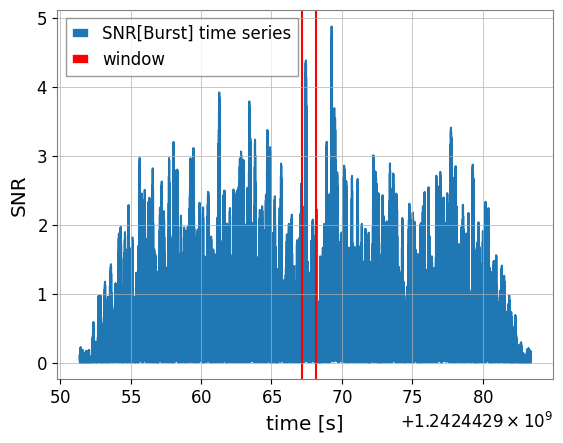

In [60]:
# convert the times to indices along with how large the region is in number of samples:
window_size1 = int((1) / SNR_burst.dt.value)
sidx1 = int((float(-0.25+time_center-SNR_burst.x0.value)) / SNR_burst.dt.value)
eidx1 = sidx1 + window_size1

plt.plot(SNR_burst,label='SNR[Burst] time series')
plt.axvline(SNR_burst.times[sidx1].value,c='r',label='window')
plt.axvline(SNR_burst.times[eidx1].value,c='r')
plt.xlabel('time [s]')
plt.ylabel('SNR')
plt.legend();

In [61]:
# Calculate the "on-source" peak SNR statistic value.
onsource1 = SNR_burst[sidx1:eidx1].max()

In [62]:
# Now that we've calculated the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks1 = []
i = 0
while i + window_size1 < len(SNR_burst):
    p1 = SNR_burst[i:i+window_size1].max()
    peaks1.append(p1)
    i += window_size1

    # Skip past the onsource time
    if abs(i - sidx1) < window_size1:
        i += window_size1 * 2

peaks1 = np.array([p1.value for p1 in peaks1])

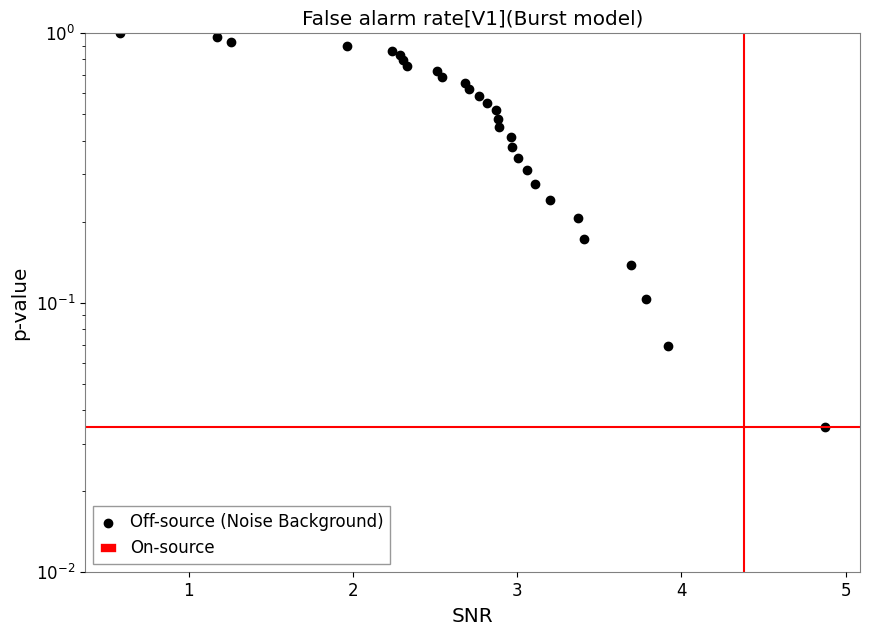

The p-value associated with the GW190521 peak is 0.034482758620689655


In [63]:
# The p-value is just the number of samples observed in the background with a
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve1 = np.arange(1, len(peaks1)+1)[::-1] / float(len(peaks1))
peaks1.sort()

pvalue1 = (peaks1 > onsource1.value).sum() / float(len(peaks1))

plt.figure(figsize=[10, 7])
plt.scatter(peaks1, pcurve1, label='Off-source (Noise Background)', color='black')

plt.axvline(onsource1.value, label='On-source', color='red')
plt.axhline(pvalue1, color='red')

plt.legend()
plt.yscale('log')
plt.grid()
plt.ylim(1e-2, 1e0)
plt.ylabel('p-value')
plt.xlabel('SNR')
plt.title('False alarm rate[V1](Burst model)')

plt.show()

print("The p-value associated with the GW190521 peak is {}".format(pvalue1))

Using the SNR calculated by the burst model template will give slightly different false alarm rate, Livingston and Hanford still being under one detection every 32 seconds.

## Parameter Estimation (25 points)
Moving to a **coherent** analysis:
- Using the CBC model, build a likelihood, prior and posterior function for the network of gravitational-wave detectors.
- Maximise that function and plot the relevant quantities.
- Interface that posterior function with a sampling algorithm (you are free to select any ready-made algorithm).
- Perform the sampling, and plot the results.
- Redo the steps above with the Burst model.
- Compare the results and discuss.

###Estimating the paramters using CBC model

In [64]:
from pycbc.detector import Detector

In [65]:
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

The right ascension and declination values were taken from -
"**Tests of Gravitational-Wave Birefringence with the Open Gravitational-Wave Catalog**"{https://arxiv.org/abs/2109.09718}

In [66]:
declination = 0.56
right_ascension =  3.4
polarization = 0.0

In [67]:
data_filt_4={}
for ifo in ifos:
  data_filt_4[ifo]=data_filt[ifo].crop(gps-2,gps+2)

In [68]:
print(data_filt_4['H1'].duration)

4.0 s


Function to generate a CBC model waveform is defined below. This includes accepting the paramter values, generating the waveform, using the atena pattern to project the signal to the detector and returning the updated waveform.

In [69]:
def gen_template(param,
                 delta_t=cropped_data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 duration=cropped_data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time=cropped_data['H1'].x0.value,# Assuming all IFOs have the same start time !
                 f_lower=10.):

    m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)#from how far back the sgnal is generated(frequency value)

    #hp.prepend_zeros(np.ceil((16+hp.start_time)/hp.delta_t))
    #hp.append_zeros(np.floor((16-hp.end_time)/hp.delta_t))
    #hc.prepend_zeros(np.ceil((16+hc.start_time)/hc.delta_t))
    #hc.append_zeros(np.floor((16-hc.end_time)/hc.delta_t))

    #hp=hp*get_window(('tukey',1/4),hp.shape[0])
    #hc=hc*get_window(('tukey',1/4),hc.shape[0])

    # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))

    ht={}
    template={}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()

        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)

        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time

        template[ifo]=TimeSeries.from_pycbc(ht[ifo])

    return template

Passing the parameters to generate the waveform

(1242442967.2, 1242442967.6000001)

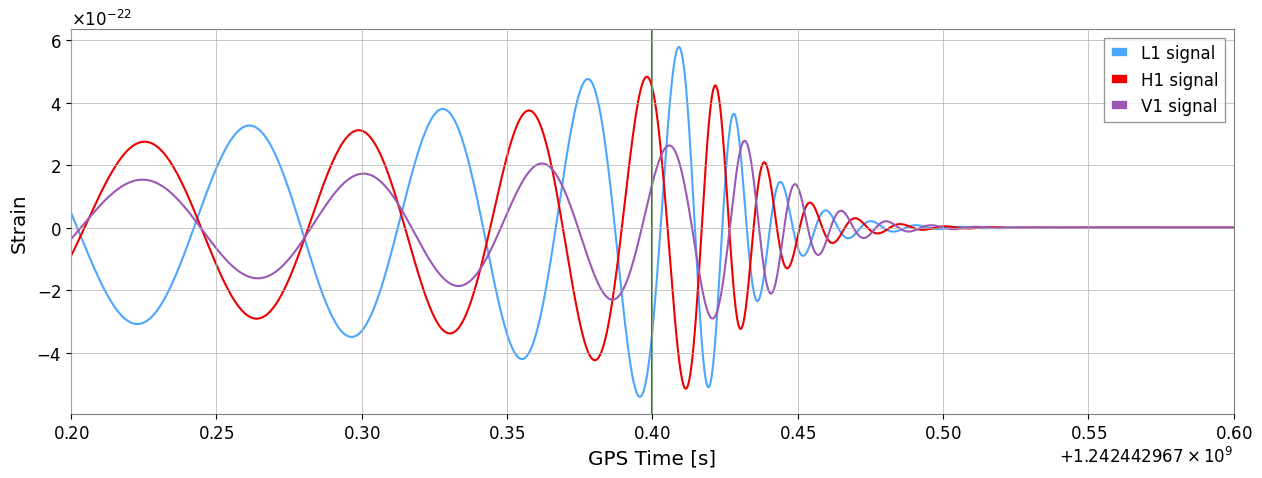

In [70]:
# Testing the gen_template() function:

param=[154.7, 120.12 , 5300 , 1242442967.4 + 0.035 , 0.0 , 3.4 , 0.56 , 0.3 , 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

template=gen_template(param)
plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
    plt.plot(template[ifo],label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='forestgreen')
plt.xlim([time_center-0.2,time_center+0.2])

Define a function to calculate loglikelihood:

In [71]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    sf[ifo] = cropped_data[ifo].average_fft(window=('tukey',1./4.))*cropped_data[ifo].duration.value/2
#4 seconds
def loglikelihood(param, sf=sf, f_lower=10.0):

    logl=0.0
    template = gen_template(param, delta_t=cropped_data['H1'].dt.value ,f_lower=f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd_32[ifo].crop(start=f_lower)

        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)

        h_dot_h  = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
        h_dot_s  = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)

        logl += h_dot_s - h_dot_h/2

    return logl.value

Pass the parameters to generate the initial value of loglikelihood:

-202.47120870980496


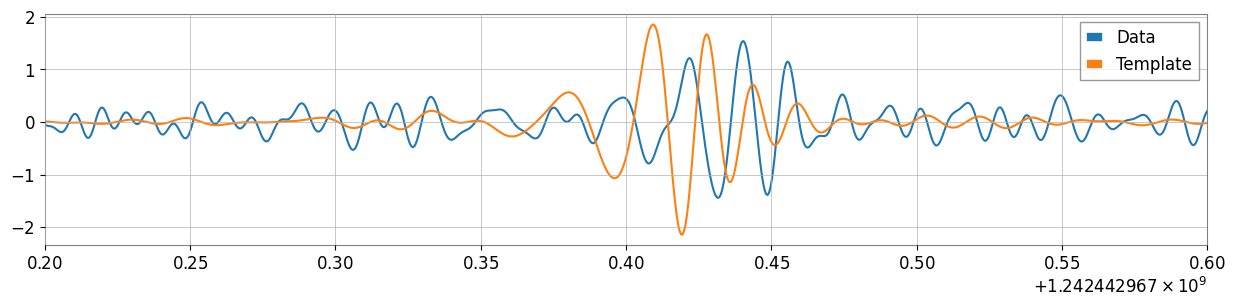

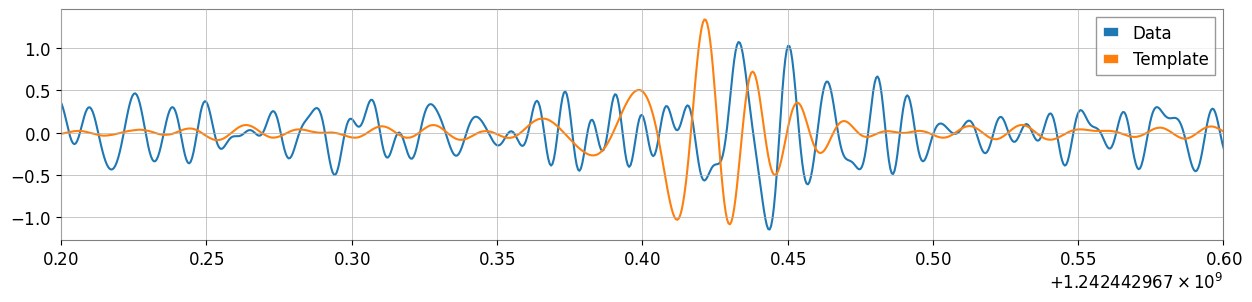

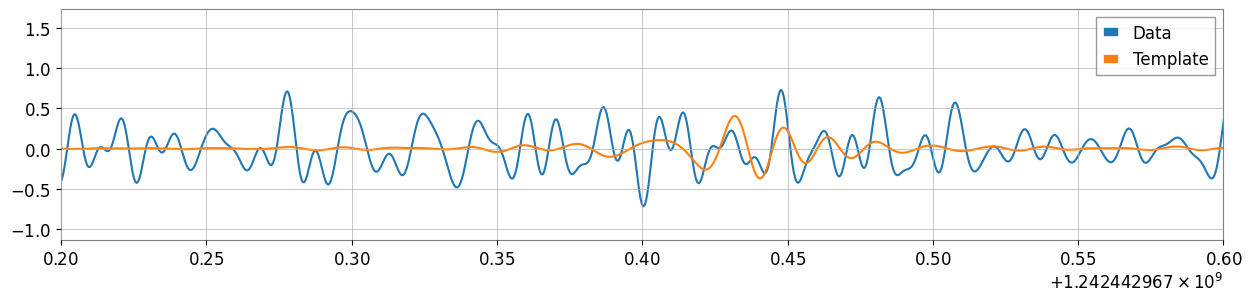

In [72]:
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization
param0 = [154.7, 120.12 , 5300 , 1242442967.4 + 0.035 , 0.0 , 3.4 , 0.56 , 0.3 , 0.]

template0 = gen_template(param0)
for ifo in ifos:
    white_template = template0[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)

    plt.figure(figsize=[15, 3])
    plt.plot(data_filt[ifo].times, data_filt[ifo], label="Data") #32 seconds
    plt.plot(white_template.times, white_template, label="Template")

    plt.xlim(time_center-.2, time_center+.2)
    plt.legend();
print(loglikelihood(param0))

Run through a minimize function which fits the waveform to the data giving us the best value of the parameters:

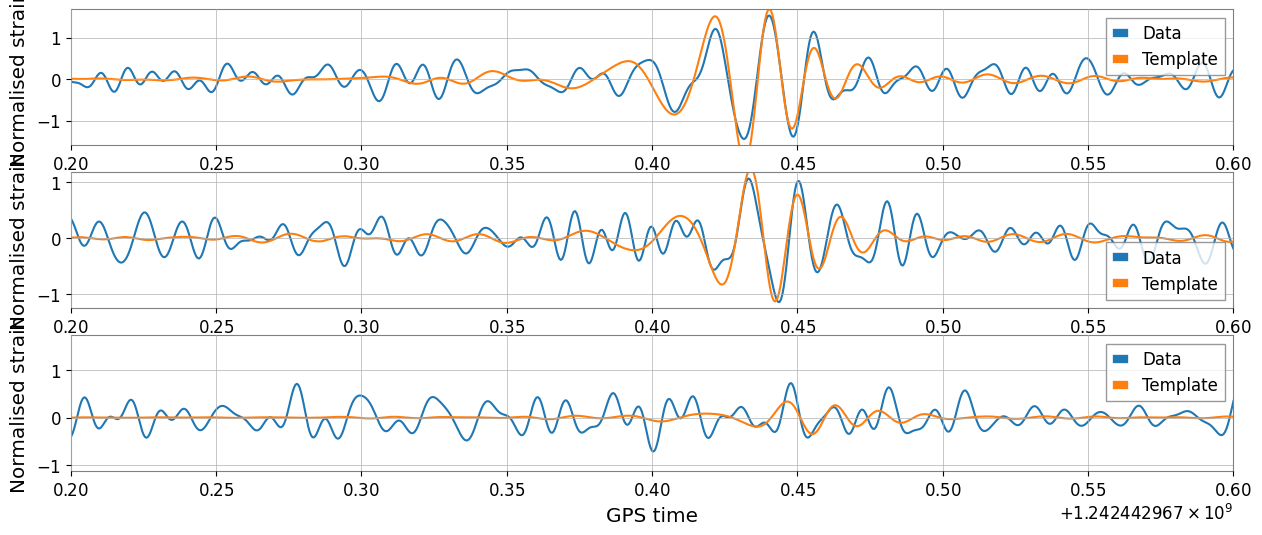

Steps	log(likelihood)
6	120.166


In [73]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)

    ax.plot(data_filt[ifo].times, data_filt[ifo], label="Data") #32seconds
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")
    ax.set_xlabel('GPS time')
    ax.set_ylabel('Normalised strain')
    ax.set_xlim(time_center-.2, time_center+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1

res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()

From the top, the first one is of Livingston, then the Hanford and the next of Virgo

In [74]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

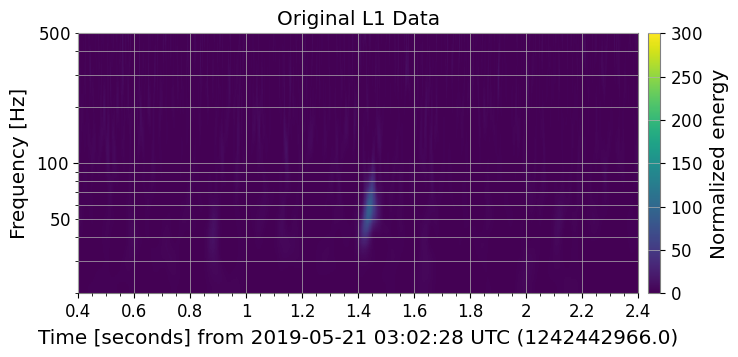

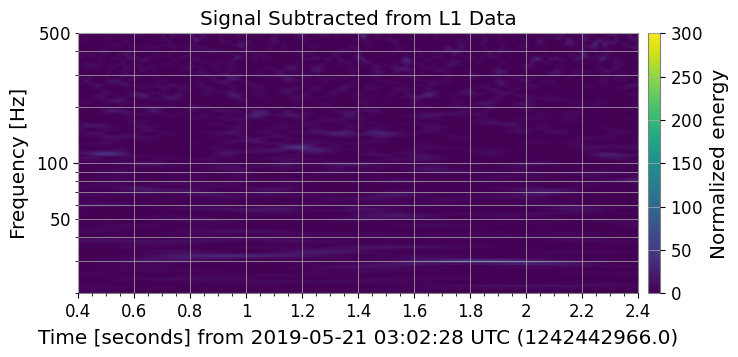

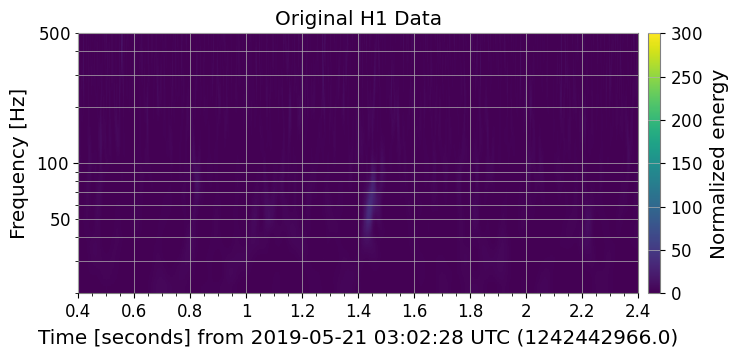

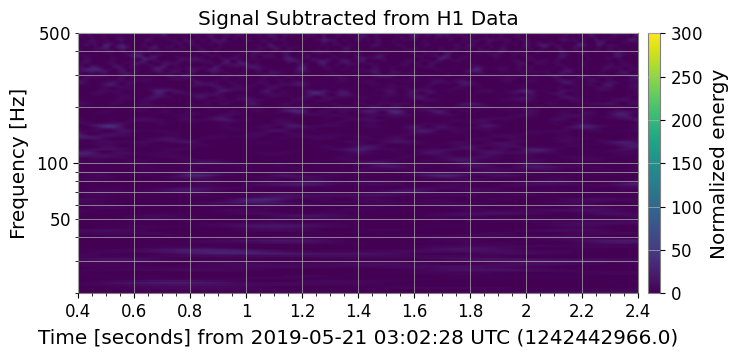

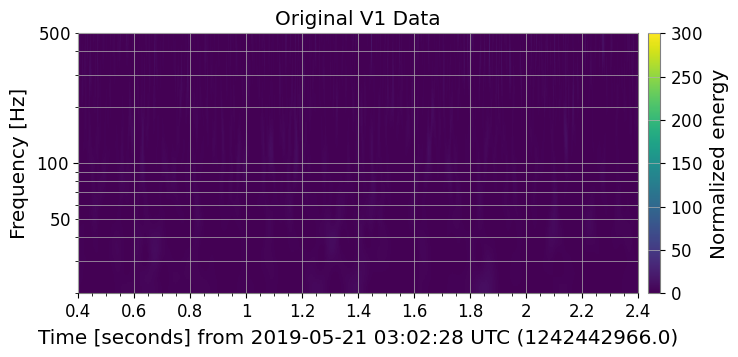

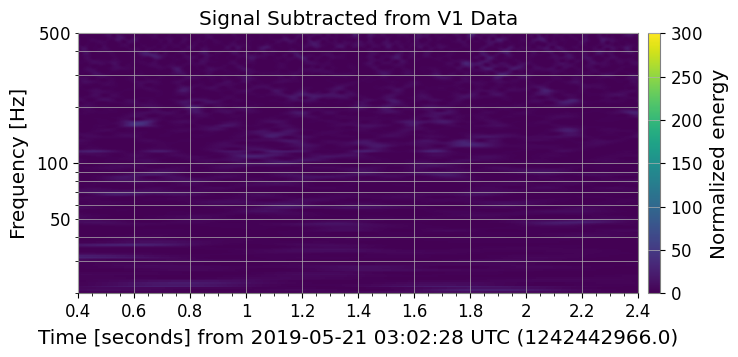

In [75]:

for i, ifo in enumerate(ifos):
    subtracted = cropped_data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                 (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        qspecgram=d.whiten(asd=np.sqrt(psd_32[ifo])).q_transform(outseg=(time_center - 1, time_center + 1),
                                                     frange=(20, 512))

        plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
        ax = plot.gca()
        ax.set_title(title)
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized energy')

We can see that the signal subtracts the matching part present in the data and leaving behing only the noise.

###Prior

Here all the paramerters are constrained avoiding all the uneccessary processing and errors

In [76]:
def logprior(param):
    logp = 0

    m1, m2, distance, time, phase, ra, dec, inclination, polarization= param

    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf
    if m1 < 0:
        return -np.inf
    if m2 < 0:
        return -np.inf

    logp += np.log(np.cos(dec))
    logp += 2*np.log(distance)
    logp += np.log(np.sin(inclination))
    logp += 2*np.log(m1)
    logp += 2*np.log(m2)
    return logp

###Posterior

In [77]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

In [78]:
logposterior(param0)

-167.04509800859284

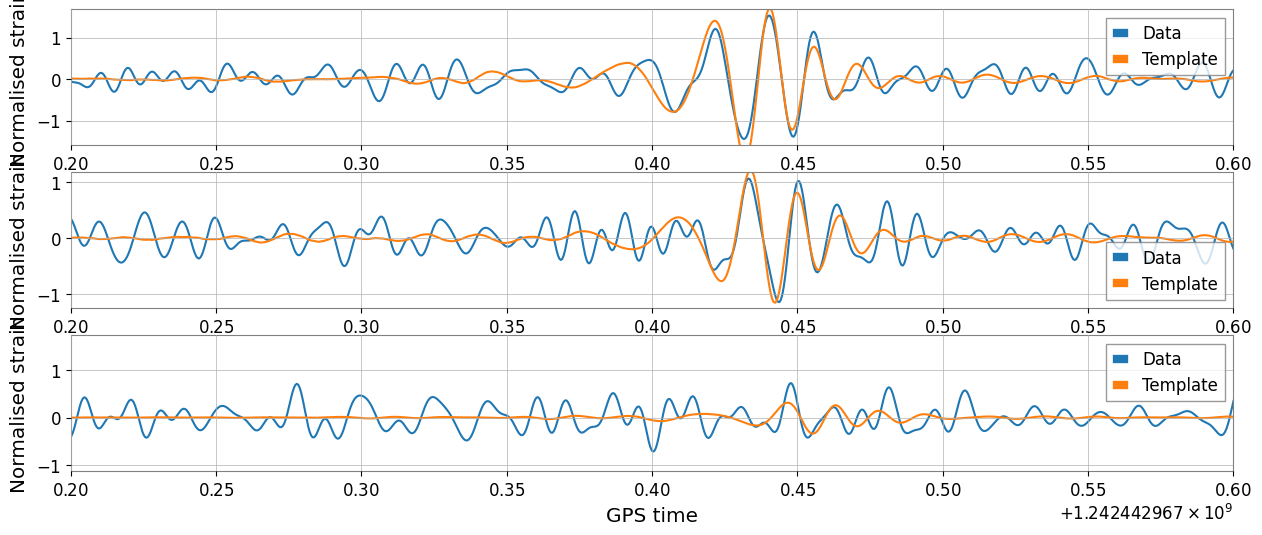

Steps	log(posterior)
11	155.845


In [79]:
fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)

    ax.plot(data_filt[ifo].times, data_filt[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")
    ax.set_xlabel('GPS time')
    ax.set_ylabel('Normalised strain')
    ax.set_xlim(time_center-.2, time_center+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res = minimize(lambda param: -logposterior(param), param0, callback=callback, method='powell')
plt.close()

The posteriror is better than the loglikelihood obtained earlier with the addition of the prior in the calculation.

In [80]:
best_guess = res.x
#print(best_guess)
print('Primary mass:', best_guess[0])
print('Secondary mass:', best_guess[1])
print('Distance:', best_guess[2])
print('Time:', best_guess[3])
print('Phase:', best_guess[4])
print('RA:', best_guess[5])
print('Dec:', best_guess[6])
print('Inclination:', best_guess[7])
print('Polarisation:', best_guess[8])

Primary mass: 156.7650485536743
Secondary mass: 98.96430238061521
Distance: 4981.398399574176
Time: 1242442967.4529414
Phase: 0.12225351237150413
RA: 3.2874685725548423
Dec: 0.5259743799118525
Inclination: 0.5503814314801155
Polarisation: 0.01132782368699748


###Estimating paramters using the burst model

In [81]:
print(cropped_data['H1'].dt.value)
print(cropped_data['H1'].duration.value)

print(cropped_data['H1'].x0.value+cropped_data['H1'].duration.value)

0.00048828125
4.0
1242442969.3999023


In [108]:
def gen_template1(param,
                 delta_t=cropped_data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 duration=cropped_data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time=cropped_data['H1'].x0.value,# Assuming all IFOs have the same start time !
                 ):

    fc , bw, amplitude, time , right_ascension, declination, polarization = param

    end_time=start_time+duration
    time_values=[]
    time_values = np.arange(start_time, end_time , delta_t)
    #time_series = TimeSeries(time_values, delta_t=cropped_data['H1'].dt.value)

    burst_hp=gausspulse(time_values, fc=fc, bw=bw)*amplitude*get_window(('tukey',1/4),2048)
    hp_burst= timeseries.TimeSeries(burst_hp, delta_t=1./cropped_data['H1'].sample_rate.to_value(), epoch=time)

    burst_hc=gausspulse(time_values, fc=fc, bw=bw)*amplitude*get_window(('tukey',1/4),2048)
    hc_burst= timeseries.TimeSeries(burst_hc, delta_t=1./cropped_data['H1'].sample_rate.to_value(), epoch=time)

    # Resize the signal buffer
    hp_burst.resize(int(duration/delta_t))
    hc_burst.resize(int(duration/delta_t))

    ht={}
    template={}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp_burst.copy() + fc * hc_burst.copy()

        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)

        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time

        template[ifo]=TimeSeries.from_pycbc(ht[ifo])

    return template

In [113]:
def gen_template1(param, delta_t=cropped_data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 duration=cropped_data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time=cropped_data['H1'].x0.value):
    # Unpack parameters
    fc, bw, amplitude, event_time, ra, dec, polarization = param

    end_time = start_time + duration

    # Create time array
    time_values = np.arange(start_time, end_time, delta_t)

    # Generate burst waveforms
    tukey_window = get_window(('tukey', 1/4), len(time_values))  # Ensure correct length
    burst_hp = gausspulse(time_values, fc=fc, bw=bw) * amplitude * tukey_window
    burst_hc = gausspulse(time_values, fc=fc, bw=bw) * amplitude * tukey_window

    # Create TimeSeries with proper delta_t and epoch
    sample_rate = 1.0 / delta_t
    hp_burst = TimeSeries(burst_hp, delta_t=delta_t, epoch=event_time)
    hc_burst = TimeSeries(burst_hc, delta_t=delta_t, epoch=event_time)

    # Resize signal buffers
    target_size = int(duration / delta_t)
    hp_burst.resize(target_size)
    hc_burst.resize(target_size)

    ht = {}
    template = {}

    # Compute detector responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(ra, dec, polarization, event_time)
        ht[ifo] = fp * hp_burst.copy() + fc * hc_burst.copy()

        # Time delay and cyclic shift logic
        time_delay = det[ifo].time_delay_from_earth_center(ra, dec, event_time)
        shift = event_time - start_time + time_delay
        ht[ifo] = ht[ifo].cyclic_time_shift(shift)
        ht[ifo].start_time = start_time

        # Convert to PyCBC TimeSeries
        template[ifo] = ht[ifo]

    return template


In [116]:
# Testing the gen_template() function:

param=[55. , 0.3 , 4e-22 , 1242442967.4-0.53 , 3.4 , 0.56, 0.]
# fc , bw, amplitude,time , right_ascension, declination, polarization = param

template=gen_template1(param)
plt.figure(figsize=(15,5))


Loop over interferometers and colors
for ifo, colour in zip(ifos, colours):
    # Ensure template exists for this ifo
    if ifo in template:
        plt.plot(template[ifo], label='{} signal'.format(ifo), color=colour)

for ifo,colour in zip(ifos,colours):
    plt.plot(template[ifo],label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='forestgreen')
plt.xlim([time_center-0.2,time_center+0.2])

SyntaxError: invalid syntax (<ipython-input-116-990d948c0d21>, line 10)

In [117]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    sf[ifo] = cropped_data[ifo].average_fft(window=('tukey',1./4.))*cropped_data[ifo].duration.value/2
#4 seconds
def loglikelihood(param, sf=sf, f_lower=10.0):

    logl=0.0
    template = gen_template1(param, delta_t=cropped_data['H1'].dt.value ,f_lower=f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd_32[ifo].crop(start=f_lower)

        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)

        h_dot_h  = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
        h_dot_s  = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)

        logl += h_dot_s - h_dot_h/2

    return logl.value

In [118]:
# center_frequency, bandwidth, amplitude = param
param1 = [55. , 0.3 , 4e-22]

template0 = gen_template1(param1)
for ifo in ifos:
    white_template = template0[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)

    plt.figure(figsize=[15, 3])
    plt.plot(data_filt[ifo].times, data_filt[ifo], label="Data") #32 seconds
    plt.plot(white_template.times, white_template, label="Template")

    plt.xlim(time_center-.2, time_center+.2)
    plt.legend();
print(loglikelihood(param1))

ValueError: not enough values to unpack (expected 7, got 3)

In [ ]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)

    ax.plot(data_filt[ifo].times, data_filt[ifo], label="Data") #32seconds
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")
    ax.set_xlabel('GPS time')
    ax.set_ylabel('Normalised strain')
    ax.set_xlim(time_center-.2, time_center+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template1(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1

res = minimize(lambda param: -loglikelihood(param), param1, callback=callback, method='powell')
plt.close()

In [ ]:
best_fit = res.x
best_fit_template = gen_template1(best_fit)

In [ ]:

for i, ifo in enumerate(ifos):
    subtracted = cropped_data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                 (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        qspecgram=d.whiten(asd=np.sqrt(psd_32[ifo])).q_transform(outseg=(time_center - 1, time_center + 1),
                                                     frange=(20, 512))

        plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
        ax = plot.gca()
        ax.set_title(title)
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized energy')

####Prior

In [ ]:
def logprior(param):
    logp = 0

    fc, bw, amplitude = param

    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if fc < 0:
        return -np.inf
    if bw < 5 or bw > 21000:
        return -np.inf
    if amplitude < 1e-23 or amplitude > 1e-18:
        return -np.inf

    logp += np.log(fc)
    logp += np.log(bw)
    logp += np.log(amplitude)
    return logp

####Posterior

In [ ]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

In [ ]:
logposterior(param0)

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)

    ax.plot(data_filt[ifo].times, data_filt[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")
    ax.set_xlabel('GPS time')
    ax.set_ylabel('Normalised strain')
    ax.set_xlim(time_center-.2, time_center+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd_32[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res = minimize(lambda param: -logposterior(param), param1, callback=callback, method='powell')
plt.close()

In [ ]:
best_guess = res.x
#print(best_guess)
print('Frequency:', best_guess[0])
print('Bandwidth:', best_guess[1])
print('Amplitude:', best_guess[2])

## Conclusions (15 points)
Minimum 300 words.
- Discuss your results in the context of the literature.
- Mention how your work compares with published results.
- Discuss some of the interpretation possibles of GW190521, including relevant citations from the literature, and summarising them.

Primary mass: 156.7650485536743 solar masses(redshifted mass)

Secondary mass: 98.96430238061521 solar masses(redshifted mass)

Distance: 4981.398399574176 Mpc

Time: 1242442967.4529414 gps time

Phase: 0.12225351237150413

RA: 3.2874685725548423

Dec: 0.5259743799118525

Inclination: 0.5503814314801155 rad

Polarisation: 0.01132782368699748

FAR-  <1 every 32 sec

SNR [‘Livingston’] – 26

SNR [‘Hanford’]  – 24

SNR [‘Virgo’]  - 4

This are the values that I have obtained.

--------------------------------------------------

The paper I refered to (https://doi.org/10.1103/PhysRevLett.125.101102) suggest the parameters to be

Primary mass 85 M⊙

Secondary mass 66 M⊙

Luminosity Distance 5.3Gpc - (approx. 5300 Mpc)

Inclination – 0.5 rad

FAR – 1 in 4900yr

SNR - 14

----------------------------------


There are a lot of degeneracies in my calculation. The paper has used an approximant called "NRSur7dq4" which represents bodies with high mass. There are mentions of multiple other approximants used to narrow down the degeneracies. These usage of models and consideration of the number of parameters used in the estimation can cause degeneracies to form in the less accurate process. In this analysis, there are constraint put on the masses and distance, inclination, that the bodies can occupy.   The false alarm rate calculated in this analysis is very limited, that is all I can tell with the length of the data being used.  I have tried to use the burst model to estimate the parameters which did not go as planned.

